In [15]:
import sys
sys.path.append("../")


import os
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from patsy import dmatrices
from openpyxl import load_workbook

from linearmodels import PanelOLS

from library import print_statistics

In [16]:
def coef_with_stars(coef, pvalue):
    coef = round(coef, 2)
    if pvalue >.05:
        coef = str(coef)
    if pvalue <= .05:
        coef = str(coef) + '*'
    if pvalue <= .01:
        coef = coef + '*'
    if pvalue <= .001:
        coef = coef + '*'
    return(coef)
test = coef_with_stars(9.1568, 0.8523)
test

'9.16'

In [17]:
def bonferroni(n_tests, coef, pvalue):
    coef = round(coef, 2)
    if pvalue >(.05/n_tests):
        coef = str(coef)
    if pvalue <= (.05/n_tests):
        coef = str(coef) + '*'
    if pvalue <= (.01/n_tests):
        coef = coef + '*'
    if pvalue <= (.001/n_tests):
        coef = coef + '*'
    return(coef)
test = bonferroni(4, .1, .005)
test

'0.1*'

In [18]:
def format_se(se):
    if se < .005:
        se = '(0.00)'
    else:
        se = '(' + str(round(se, 2)) + ')'
    return se
test = format_se(.0053)
test

'(0.01)'

In [19]:
data_path = '/Users/kylieleblancKylie/domino/dofis/data/'
table_path = '/Users/kylieleblancKylie/domino/dofis/results/Who Needs Rules/'
data = pd.read_csv(os.path.join(data_path, 'clean', 'gdid_subject.csv'),
                  sep=",", low_memory= False)
#load(data)
print(data[data.doi == True].district.nunique())
data.sample()

822


,Unnamed: 0,campus,year,test,score,score_std,campname,campischarter,district,distname,...,pre5,pre4,pre3,pre2,pre1,pre0,post1,post2,post3,test_by_year
40554,49616,71906041,2015,r_6th_avescore,1553.0,-0.717336,ANTHONY MIDDLE,N,71906,ANTHONY ISD,...,0,0,0,0,1,0,0,0,0,r_6th_avescore2015


In [20]:
data.doi_year.value_counts()

2017.0    170699
2018.0     39859
2016.0     38209
2019.0      8127
Name: doi_year, dtype: int64

In [21]:
# phase-in effect (yearpost)
data[['year', 'doi_year', 'treatpost', 'yearpost']].sample(10)

,year,doi_year,treatpost,yearpost
199279,2017,2017.0,False,0.0
37159,2015,2017.0,False,0.0
95379,2019,2017.0,True,1.0
42437,2015,2019.0,False,0.0
125532,2013,2016.0,False,0.0
102975,2012,2017.0,False,0.0
205879,2017,2017.0,False,0.0
230751,2019,2017.0,True,1.0
168343,2015,2017.0,False,0.0
152804,2014,2017.0,False,0.0


In [22]:
data.yearpost.value_counts()

0.0    228009
1.0     26643
2.0      4983
Name: yearpost, dtype: int64

## Pretrends - yearpre

In [23]:
# Pre-trends
data[['year', 'doi_year', 'treatpost', 'yearpost', 'yearpre']].sample(5)

,year,doi_year,treatpost,yearpost,yearpre
248347,2018,2017.0,True,0.0,0.0
29173,2014,2017.0,False,0.0,-3.0
101608,2012,2016.0,False,0.0,-4.0
210014,2018,2018.0,False,0.0,0.0
78980,2018,2018.0,False,0.0,0.0


In [24]:
data.yearpre.value_counts()

 0.0    98430
-1.0    32224
-2.0    31991
-3.0    31762
-4.0    31526
-5.0    26857
-6.0     5877
-7.0      968
Name: yearpre, dtype: int64

In [25]:
#convert year to datetime
df = data.reset_index()
df['year'] = pd.to_datetime(df['year'], format='%Y')
#add column year to index
df = data.set_index(['year', 'campus'])
#swap indexes
df.index = df.index.swaplevel(0,1)
df[['district', 'doi_year','treatpost']].sample(5, random_state = 8)

,,district,doi_year,treatpost
campus,year,,,
251901101,2016,251901,2017.0,False
43905118,2016,43905,2017.0,False
57919041,2014,57919,2017.0,False
9901101,2013,9901,2017.0,False
220901119,2012,220901,2016.0,False


# Specifications

In [26]:
# Get table ready
file = table_path + 'table3_gdid_and_event.xlsx'
wb = load_workbook(file)
ws = wb.active

## Simple GDID

In [27]:
test = pd.Categorical(df.test)
mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + students_hisp + students_num + C(test_by_year) + EntityEffects', df)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)
ws.cell(row= 3, column= 2).value = coef_with_stars(res.params['treatpost[T.True]'], res.pvalues['treatpost[T.True]'])
ws.cell(row= 4, column= 2).value = format_se(res.std_errors['treatpost[T.True]'])

                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.2149
Estimator:                   PanelOLS   R-squared (Between):             -0.2030
No. Observations:              259635   R-squared (Within):               0.2149
Date:                Sat, Dec 28 2019   R-squared (Overall):              0.0379
Time:                        09:05:39   Log-likelihood                -1.961e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      568.61
Entities:                        6102   P-value                           0.0000
Avg Obs:                       42.549   Distribution:              F(122,253411)
Min Obs:                       1.0000                                           
Max Obs:                       120.00   F-statistic (robust):             300.87
                            

## GDID with Trends

In [28]:
mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + yearpost + yearpre + students_hisp + students_num + C(test_by_year) + EntityEffects', df)
#mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + yearpost + yearpre + students_hisp + students_num + TimeEffects + EntityEffects', df)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)
#intercept = res.params['Intercept']
jump = res.params['treatpost[T.True]']
preslope = res.params['yearpre']
preslope_se = res.std_errors['yearpre']
postslope = res.params['yearpost']
post_slope = res.std_errors['yearpost']
ws.cell(row= 6, column= 2).value = coef_with_stars(res.params['treatpost[T.True]'], res.pvalues['treatpost[T.True]'])
ws.cell(row= 7, column= 2).value = format_se(res.std_errors['treatpost[T.True]'])
ws.cell(row= 8, column= 2).value = coef_with_stars(res.params['yearpost'], res.pvalues['yearpost'])
ws.cell(row= 9, column= 2).value = format_se(res.std_errors['yearpost'])
ws.cell(row= 10, column= 2).value = coef_with_stars(res.params['yearpre'], res.pvalues['yearpre'])
ws.cell(row= 11, column= 2).value = format_se(res.std_errors['yearpre'])
wb.save(file)

                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.2150
Estimator:                   PanelOLS   R-squared (Between):             -0.2034
No. Observations:              259635   R-squared (Within):               0.2150
Date:                Sat, Dec 28 2019   R-squared (Overall):              0.0376
Time:                        09:06:10   Log-likelihood                -1.961e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      559.78
Entities:                        6102   P-value                           0.0000
Avg Obs:                       42.549   Distribution:              F(124,253409)
Min Obs:                       1.0000                                           
Max Obs:                       120.00   F-statistic (robust):             297.47
                            

# Non-parametric event study

In [29]:
mod = PanelOLS.from_formula('score_std ~ + 1 + pre5 + pre4 + pre3 + pre2 + pre1 + post1 + post2 + post3 + students_hisp + students_num + C(test_by_year) + EntityEffects', df)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)
nonparametric = []
nonparametric_se = []
for coef in ['pre5', 'pre4', 'pre3', 'pre2', 'pre1', 'pre0', 'post1', 'post2', 'post3']:
    nonpar = 0
    nonpar_se = 0
    if coef != 'pre0':
        nonpar = res.params[coef]
        nonpar_se = res.std_errors[coef]
    nonparametric.append(nonpar)
    nonparametric_se.append(nonpar_se)
print(nonparametric)
row = 3
for coef in ['post3', 'post2', 'post1', 'pre1', 'pre2', 'pre3', 'pre4', 'pre5']:
    ws.cell(row= row, column= 4).value = coef_with_stars(res.params[coef], res.pvalues[coef])
    row = row + 1
    ws.cell(row= row, column= 4).value = format_se(res.std_errors[coef])  
    row = row + 1
wb.save(file)

                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.2151
Estimator:                   PanelOLS   R-squared (Between):             -0.2035
No. Observations:              259635   R-squared (Within):               0.2151
Date:                Sat, Dec 28 2019   R-squared (Overall):              0.0376
Time:                        09:06:32   Log-likelihood                -1.961e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      538.27
Entities:                        6102   P-value                           0.0000
Avg Obs:                       42.549   Distribution:              F(129,253404)
Min Obs:                       1.0000                                           
Max Obs:                       120.00   F-statistic (robust):             285.88
                            

In [30]:
coef_df = pd.DataFrame({'coef': nonparametric,
                        'err': nonparametric_se,
                        'year': [-5, -4, -3, -2, -1,0 , 1, 2, 3]
                       })
coef_df['lb'] = coef_df.coef - (1.96*coef_df.err)
coef_df['ub'] = coef_df.coef + (1.96*coef_df.err)
coef_df

,coef,err,year,lb,ub
0,0.002700,0.038859,-5,-0.073464,0.078864
1,0.008275,0.031436,-4,-0.053340,0.069890
2,0.024910,0.024835,-3,-0.023767,0.073587
3,0.018117,0.017512,-2,-0.016206,0.052440
4,0.005759,0.009651,-1,-0.013157,0.024676
5,0.000000,0.000000,0,0.000000,0.000000
6,-0.023790,0.010405,1,-0.044184,-0.003397
7,-0.051358,0.020088,2,-0.090730,-0.011986
8,-0.078384,0.031185,3,-0.139507,-0.017262


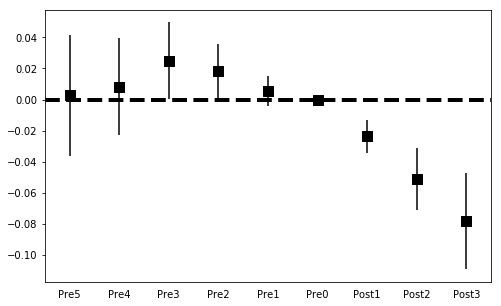

In [31]:
fig, ax = plt.subplots(figsize=(8, 5))
coef_df.plot(x='year', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=120, 
           y=coef_df['coef'], color='black')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.xaxis.set_ticks_position('none')
_ = ax.set_xticklabels(['Pre5', 'Pre4', 'Pre3', 'Pre2', 'Pre1', 'Pre0', 'Post1', 'Post2', 'Post3'], 
                       rotation=0)
#ax.set_title('Impact on Student Achievement - Event Study Coefficients', fontsize = 16)

# Create graph (look up how to use predicted values)


In [32]:
years = [-5, -4, -3, -2, -1, 0, 1, 2, 3]
parametric = []
parametric_lb = []
for year in years:
    par = 0
    if year < 0 :
        par = (year * preslope)
    if year > 0 :
        par = jump + (year * postslope)
    parametric.append(par)
parametric

[-0.03142226153831265,
 -0.02513780923065012,
 -0.01885335692298759,
 -0.01256890461532506,
 -0.00628445230766253,
 0,
 -0.041510725039469704,
 -0.0629332482683688,
 -0.08435577149726789]

In [33]:
nonparametric

[0.0026997415851054973,
 0.008274800589256281,
 0.024910078610324016,
 0.018117012679355976,
 0.00575948843761645,
 0,
 -0.023790314881633245,
 -0.05135845351807167,
 -0.07838412579023613]

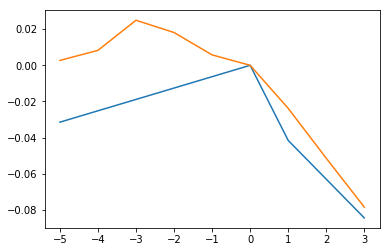

In [34]:
plt.plot(years, parametric)
plt.plot(years, nonparametric)

# Table by Subject

In [35]:
subjects = ['m_3rd_avescore', 'r_3rd_avescore',
            'm_4th_avescore', 'r_4th_avescore', 
            'm_5th_avescore', 'r_5th_avescore', 
            'm_6th_avescore', 'r_6th_avescore',
            'm_7th_avescore', 'r_7th_avescore',
            'm_8th_avescore', 'r_8th_avescore',
            'alg_avescore', 'bio_avescore', 'eng1_avescore']

In [36]:
# All Subject Table
file = table_path + 'tableA_effect_by_subject.xlsx'
wb = load_workbook(file)
ws = wb.active

col = 3
for subject in subjects:
    
    df_sub = df[df.test == subject]
    test = pd.Categorical(df_sub.test)
    
    # GDID
    mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + students_hisp + students_num + C(test_by_year) + EntityEffects', df_sub)
    res = mod.fit(cov_type='clustered', cluster_entity=True)
    ws.cell(row= 4, column= col).value = bonferroni(len(subjects), res.params['treatpost[T.True]'], res.pvalues['treatpost[T.True]'])
    ws.cell(row= 5, column= col).value = format_se(res.std_errors['treatpost[T.True]'])

    # GDID with Trend
    mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + yearpost + yearpre + students_hisp + students_num + C(test_by_year) + EntityEffects', df_sub)
    #mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + yearpost + yearpre + students_hisp + students_num + TimeEffects + EntityEffects', df_sub)
    res = mod.fit(cov_type='clustered', cluster_entity=True)
    jump = res.params['treatpost[T.True]']
    preslope = res.params['yearpre']
    preslope_se = res.std_errors['yearpre']
    postslope = res.params['yearpost']
    post_slope = res.std_errors['yearpost']
    ws.cell(row= 7, column= col).value = bonferroni(len(subjects), res.params['treatpost[T.True]'], res.pvalues['treatpost[T.True]'])
    ws.cell(row= 8, column= col).value = format_se(res.std_errors['treatpost[T.True]'])
    ws.cell(row= 9, column= col).value = bonferroni(len(subjects), res.params['yearpost'], res.pvalues['yearpost'])
    ws.cell(row= 10, column= col).value = format_se(res.std_errors['yearpost'])
    ws.cell(row= 11, column= col).value = bonferroni(len(subjects), res.params['yearpre'], res.pvalues['yearpre'])
    ws.cell(row= 12, column= col).value = format_se(res.std_errors['yearpre'])
    wb.save(file)

    # Event Study
    mod = PanelOLS.from_formula('score_std ~ + 1 + pre5 + pre4 + pre3 + pre2 + pre1 + post1 + post2 + post3 + students_hisp + students_num + C(test_by_year) + EntityEffects', df_sub)
    res = mod.fit(cov_type='clustered', cluster_entity=True)
    nonparametric = []
    nonparametric_se = []
    for coef in ['pre5', 'pre4', 'pre3', 'pre2', 'pre1', 'pre0', 'post1', 'post2', 'post3']:
        nonpar = 0
        nonpar_se = 0
        if coef != 'pre0':
            nonpar = res.params[coef]
            nonpar_se = res.std_errors[coef]
        nonparametric.append(nonpar)
        nonparametric_se.append(nonpar_se)
    print(nonparametric)
    row = 14
    for coef in ['post3', 'post2', 'post1', 'pre1', 'pre2', 'pre3', 'pre4', 'pre5']:
        ws.cell(row= row, column= col).value = bonferroni(len(subjects), res.params[coef], res.pvalues[coef])
        row = row + 1
        ws.cell(row= row, column= col).value = format_se(res.std_errors[coef])  
        row = row + 1
    wb.save(file)
    col = col + 1

[0.022481239435034432, 0.00731172208747676, 0.07259537529277157, 0.05893286329597401, 0.024060656922063793, 0, -0.03983628433448356, -0.09409455109626833, -0.1681887037123887]
[0.09994184856058155, 0.08128882803056042, 0.08091412455620997, 0.04488889538282219, 0.017968491057759547, 0, -0.029348004469085802, -0.08761208590816873, -0.12775516931407713]
[0.028854631961264903, 0.047178000641880505, 0.07032317970805926, 0.0548870565555823, 0.01501770970391966, 0, -0.038642531695041754, -0.0694060653766969, -0.11840890896121258]
[0.02474061829970201, 0.022510425841796473, 0.01820424820281831, 0.01234045397887476, 0.013615668195678006, 0, -0.011040320615167618, -0.03052261610606375, -0.03256951318363104]
[-0.06288321159280587, -0.02824816827747271, 0.014800983842962754, 0.013595763289946772, 0.004867809649593345, 0, -0.03406082759103918, -0.05363315995394577, -0.10705319590553722]
[-0.05237643588891397, 0.010925393931108064, 0.02433877366057983, -0.0172973027680243, -0.0044008696343850575, 0,

# Effects without 6th Grade Math

In [37]:
file = table_path + 'tableA2_gdid_and_event.xlsx'
wb = load_workbook(file)
ws = wb.active


df_limited = df[df.test != 'm_6th_avescore']

test = pd.Categorical(df_limited.test)
mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + students_hisp + students_num + C(test_by_year) + EntityEffects', df_limited)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)
ws.cell(row= 3, column= 2).value = coef_with_stars(res.params['treatpost[T.True]'], res.pvalues['treatpost[T.True]'])
ws.cell(row= 4, column= 2).value = format_se(res.std_errors['treatpost[T.True]'])

mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + yearpost + yearpre + students_hisp + students_num + C(test_by_year) + EntityEffects', df_limited)
#mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + yearpost + yearpre + students_hisp + students_num + TimeEffects + EntityEffects', df_limited)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)
#intercept = res.params['Intercept']
jump = res.params['treatpost[T.True]']
preslope = res.params['yearpre']
preslope_se = res.std_errors['yearpre']
postslope = res.params['yearpost']
post_slope = res.std_errors['yearpost']
ws.cell(row= 6, column= 2).value = coef_with_stars(res.params['treatpost[T.True]'], res.pvalues['treatpost[T.True]'])
ws.cell(row= 7, column= 2).value = format_se(res.std_errors['treatpost[T.True]'])
ws.cell(row= 8, column= 2).value = coef_with_stars(res.params['yearpost'], res.pvalues['yearpost'])
ws.cell(row= 9, column= 2).value = format_se(res.std_errors['yearpost'])
ws.cell(row= 10, column= 2).value = coef_with_stars(res.params['yearpre'], res.pvalues['yearpre'])
ws.cell(row= 11, column= 2).value = format_se(res.std_errors['yearpre'])
wb.save(file)

mod = PanelOLS.from_formula('score_std ~ + 1 + pre5 + pre4 + pre3 + pre2 + pre1 + post1 + post2 + post3 + students_hisp + students_num + C(test_by_year) + EntityEffects', df_limited)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)
nonparametric = []
nonparametric_se = []
for coef in ['pre5', 'pre4', 'pre3', 'pre2', 'pre1', 'pre0', 'post1', 'post2', 'post3']:
    nonpar = 0
    nonpar_se = 0
    if coef != 'pre0':
        nonpar = res.params[coef]
        nonpar_se = res.std_errors[coef]
    nonparametric.append(nonpar)
    nonparametric_se.append(nonpar_se)
print(nonparametric)
row = 3
for coef in ['post3', 'post2', 'post1', 'pre1', 'pre2', 'pre3', 'pre4', 'pre5']:
    ws.cell(row= row, column= 4).value = coef_with_stars(res.params[coef], res.pvalues[coef])
    row = row + 1
    ws.cell(row= row, column= 4).value = format_se(res.std_errors[coef])  
    row = row + 1
wb.save(file)

                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.2172
Estimator:                   PanelOLS   R-squared (Between):             -0.1634
No. Observations:              246320   R-squared (Within):               0.2172
Date:                Sat, Dec 28 2019   R-squared (Overall):              0.0523
Time:                        09:07:20   Log-likelihood                -1.852e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      584.29
Entities:                        6102   P-value                           0.0000
Avg Obs:                       40.367   Distribution:              F(114,240104)
Min Obs:                       1.0000                                           
Max Obs:                       112.00   F-statistic (robust):             309.37
                            

                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.2173
Estimator:                   PanelOLS   R-squared (Between):             -0.1636
No. Observations:              246320   R-squared (Within):               0.2173
Date:                Sat, Dec 28 2019   R-squared (Overall):              0.0521
Time:                        09:07:43   Log-likelihood                -1.852e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      574.57
Entities:                        6102   P-value                           0.0000
Avg Obs:                       40.367   Distribution:              F(116,240102)
Min Obs:                       1.0000                                           
Max Obs:                       112.00   F-statistic (robust):             305.59
                            

                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.2173
Estimator:                   PanelOLS   R-squared (Between):             -0.1637
No. Observations:              246320   R-squared (Within):               0.2173
Date:                Sat, Dec 28 2019   R-squared (Overall):              0.0521
Time:                        09:08:11   Log-likelihood                -1.852e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      551.00
Entities:                        6102   P-value                           0.0000
Avg Obs:                       40.367   Distribution:              F(121,240097)
Min Obs:                       1.0000                                           
Max Obs:                       112.00   F-statistic (robust):             292.85
                            